# Data mining \& clustering

The goal if this practical is to adress the folowing problem:

<span style="color:red" >Given XXX raw, unlabeled documents, ... How to exploit/understand/represent them?</span>

In the previous week, we have seen how to represent textual data with the Bag of Words (BoW) model:

$$
X =
\begin{matrix}
& \textbf{t}_j \\
& \downarrow \\
\textbf{d}_i \rightarrow &
    \begin{pmatrix}
    x_{1,1} & \dots & x_{1,d} \\
    \vdots & \ddots & \vdots \\
    x_{N,1} & \dots & x_{N,d} \\
    \end{pmatrix}
\end{matrix}
$$

From this BoW representation, we want to answer the following questions:

1. Which clustering algorithm to choose?
   - K-means, LSA, pLSA, LDA
1. What results to expect?
   - Semantics, noise cleaning, etc...
1. Which qualitative and quantitative analyses to understand the groups?
   [comment]: <> (%1. Comment boucler, itérer pour améliorer la qualité du processus?)

<span style="color:magenta" > In this practical, we use a **labeled dataset** in order to evaluate performances with quantitative and well-defined metrics. </span>


In [96]:
import codecs, re, os.path
import numpy as np
import matplotlib.pyplot as plt
import sklearn


## Data loading


In [97]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset="train", data_home="./data")
labels = newsgroups_train.target


In [98]:
# conversion BoW + tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words="english")

vectors = vectorizer.fit_transform(newsgroups_train.data)
print("shape =", vectors.shape)

# sparsity measure = 44 active words over 1000 per document (157 over 130000) !!
print("sparsity measure =", vectors.nnz / float(vectors.shape[0]))


shape = (11314, 1000)
sparsity measure = 44.164928407283014


In [99]:
# retrieve words
print([(i, vectorizer.get_feature_names_out()[i]) for i in np.random.randint(vectors.shape[1], size=10)])


[(684, 'peter'), (504, 'isn'), (38, '30'), (582, 'manager'), (540, 'league'), (315, 'different'), (961, 'washington'), (681, 'period'), (754, 'reference'), (999, 'young')]


In [100]:
# labels (only for evaluation)
Y = newsgroups_train.target
print(Y[:10])
print([newsgroups_train.target_names[i] for i in Y[:20]])  # vraie classe


[ 7  4  4  1 14 16 13  3  2  4]
['rec.autos', 'comp.sys.mac.hardware', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space', 'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware', 'rec.motorcycles', 'talk.religion.misc', 'comp.sys.mac.hardware', 'sci.space', 'misc.forsale', 'alt.atheism', 'comp.graphics', 'rec.autos', 'sci.electronics', 'comp.windows.x']


# 0) Word clouds

Drawing word clouds from the raw corpus or words' frequencies: [make word clouds!](https://github.com/amueller/word_cloud)

## Installation

If you are using `pip`:

    pip install wordcloud

If you are using `conda`, you can install from the `conda-forge` channel:

    conda install -c conda-forge wordcloud


## Let's look at the most frequent words in this dataset


In [109]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

data = np.array(newsgroups_train.data)
corpus = "".join(data)
words = corpus.split()  # optional args to choose the splitting chars
print("Nb mots =", len(words))

# Lets find the most frequent words
vectorizer2 = CountVectorizer()
X2 = vectorizer2.fit_transform(data)
frequent_words = pd.Series(np.array(X2.sum(axis=0))[0], index=sorted(vectorizer2.vocabulary_))
frequent_words = frequent_words.sort_values(ascending=False)
print("20 most frequent words")
print(frequent_words[:20])


Nb mots = 3252437
20 most frequent words
the     146532
to       75064
of       69034
ax       62406
and      57957
in       49401
is       43480
that     39264
it       33638
for      28600
you      26682
from     22670
edu      21321
on       20491
this     20121
be       19285
are      18616
not      18424
have     18074
with     17325
dtype: int64


### Plot the $N$ frequent words and verify that it follows a Zipf's law


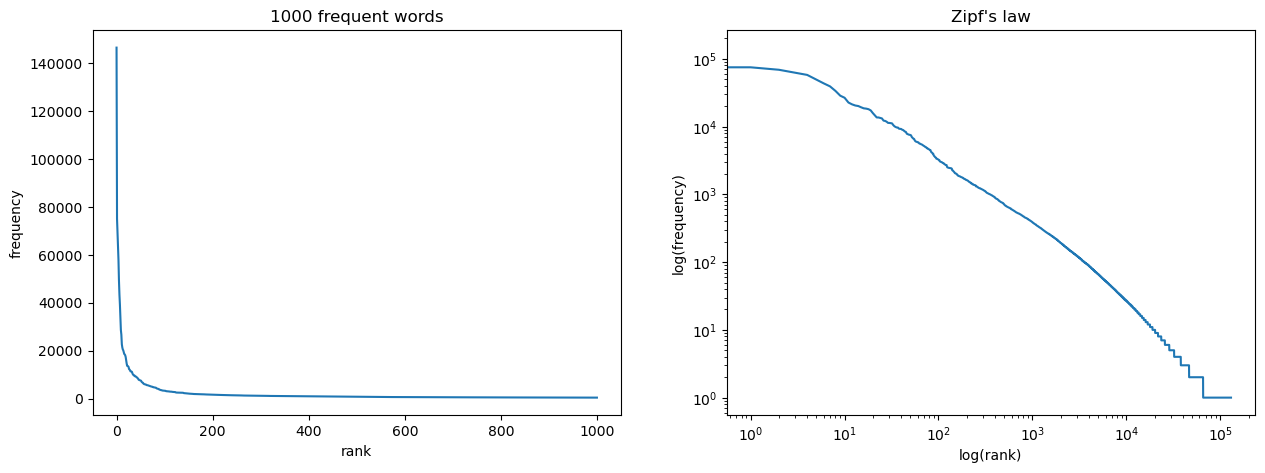

In [102]:
N = 1000

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(N), frequent_words[:N])
plt.ylabel("frequency")
plt.xlabel("rank")
plt.title("1000 frequent words")
plt.subplot(122)
plt.plot(frequent_words)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("log(rank)")
plt.ylabel("log(frequency)")
plt.title("Zipf's law")
plt.show()


### Experiment word clouds


Without using stopwords:


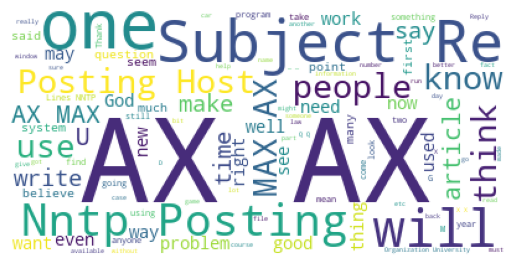

In [103]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(background_color="white", max_words=100).generate(corpus)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()


Using stopwords:


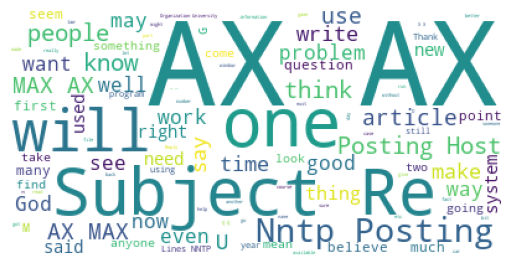

In [104]:
wordcloud = WordCloud(background_color="white", stopwords=STOPWORDS, max_words=100).generate(corpus)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()


### Drawing word clouds with `generate_from_frequencies`

_N.B._: retrieve the most words frequencies using a CountVectorizer


Using `vectorizer2`, without stopwords:


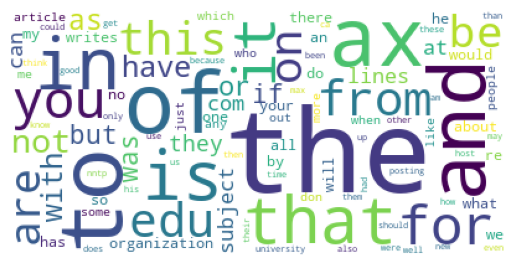

In [105]:
wordcloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(frequent_words)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()


Using `wordcloud` stopwords:


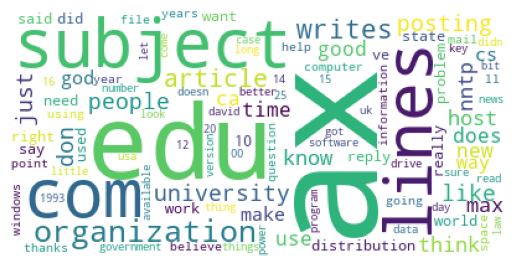

In [108]:
wordcloud = WordCloud(background_color="white", stopwords=STOPWORDS, max_words=100).generate_from_frequencies(
    frequent_words
)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


Using `nltk` stopwords:


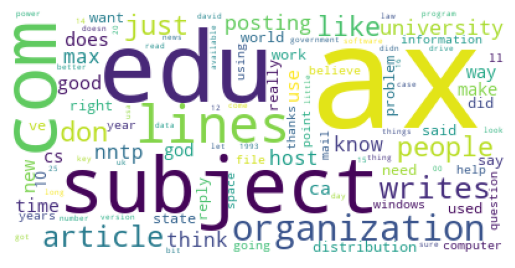

In [106]:
vectorizer2 = CountVectorizer(stop_words="english")
X2 = vectorizer2.fit_transform(data)
frequent_words = pd.Series(np.array(X2.sum(axis=0))[0], index=sorted(vectorizer2.vocabulary_))
wordcloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(frequent_words)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()


### Drawing word clouds from classes


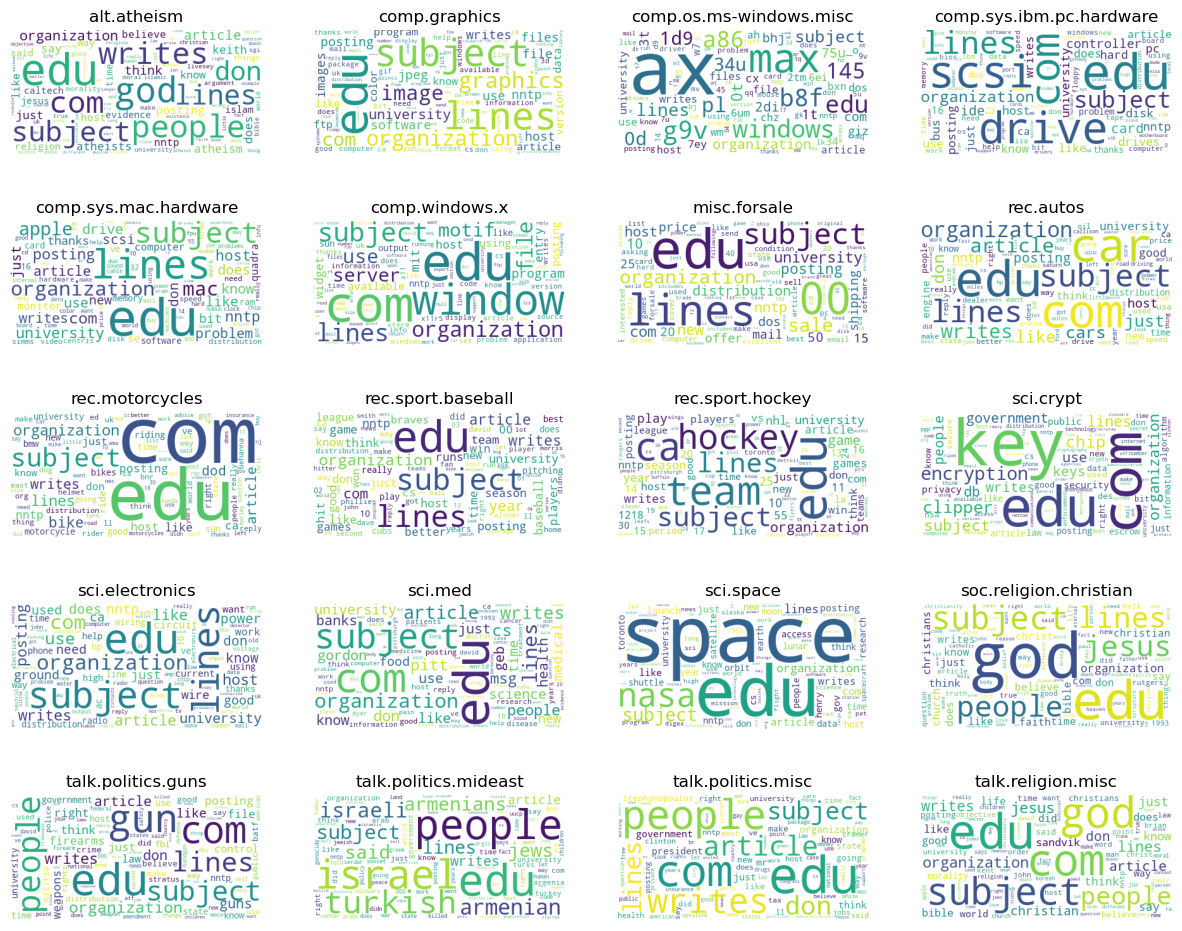

In [94]:
classes = np.unique(Y)
print(f"number of classes : {len(classes)}")

fig, ax = plt.subplots(5, 4, figsize=(15, 12))
ax = ax.flatten()
for cl in classes:
    vectorizer2 = CountVectorizer(stop_words="english")
    X2 = vectorizer2.fit_transform(data[Y==classes[cl]])
    frequent_words = pd.Series(np.array(X2.sum(axis=0))[0], index = sorted(vectorizer2.vocabulary_))
    wordcloud = WordCloud(background_color='white',max_words=100).generate_from_frequencies(frequent_words)
    ax[cl].imshow(wordcloud)
    ax[cl].axis("off")
    ax[cl].set_title(newsgroups_train.target_names[cl])
    

# 1) Clustering algorithm: K-Means

**Let's start by the most famous and simple unsupervised algorithm: $k$-means!**
Look at [`sklearn` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
and apply it to your BoW matrix.


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=0, max_iter=10)
kmeans.fit(vectors)

# Getting clusters:
cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
print(f"Number of clusters: {len(cluster_sizes)}")
print(f"Number of elements assigned to each cluster: {cluster_sizes}")
clusters = kmeans.cluster_centers_

print(f"Rand score = {sklearn.metrics.rand_score(labels, kmeans.labels_):.3f}")
print(f"Adjusted Rand score = {sklearn.metrics.adjusted_rand_score(labels, kmeans.labels_):.3f}")


Number of clusters: 20
Number of elements assigned to each cluster: [ 297 1681 1436  263  537  535  394  340   98  206  330  349 1671  238
 1202  504  565  176  162  330]
Rand score = 0.885
Adjusted Rand score = 0.111


In [ ]:
kmeans.labels_  # = Y


array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

### Clustering Analysis:

1. **Qualtitative:**
   - Look at the most important words for each cluster
   - Perform cluster assignement to each document, and compute word cloud on the document (raw text or frequencies)

$\forall j, \hat j = \text{argmin}\_{i \in {1;K}} || d_j - c_i ||^2 $

2. **Quantitative:**
   - Compute cluster "purity": $p_j= |y^*_j|$, where $y^*_j$ is the most frequent (GT) label in cluster $C_j$ $\Rightarrow$ $p = \frac{1}{N}\sum\limits_j  p_j$
   - Compute [Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html) and [Adjusted Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score)


Normaliser pour aider les k-means


# 2) Latent Semantic Analysis (LSA <=> SVD)


**Remember the LSA factorziation**:

$$
\begin{matrix}
 & X  &\!\!\!\!\!=\!\!\!\!\!& U  & \Sigma & V^T \\
  & \textbf{t}_j   &  & \hat{ \textbf{d}_i} & &  \\
 & \downarrow  &  &\downarrow  & & \\
\textbf{d}_i \rightarrow
&
\begin{pmatrix}
x_{1,1} & \dots & x_{1,d} \\
\\
\vdots & \ddots & \vdots \\
\\
x_{N,1} & \dots & x_{N,d} \\
\end{pmatrix}
&
\!\!\!\!\!=\!\!\!\!\!
%&
%(\hat{ \textbf{t}_j}) \rightarrow
&
\begin{pmatrix}
\begin{pmatrix} &  \textbf{u}_1 &  \end{pmatrix} \\
\vdots \\
\begin{pmatrix}  & \textbf{u}_k &  \end{pmatrix}
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix}
\sigma_1 & \dots & 0 \\
\vdots & \ddots & \vdots \\
0 & \dots & \sigma_k \\
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix}
\begin{pmatrix} \, \\ \, \\ \textbf{v}_1 \\ \, \\ \,\end{pmatrix}
\dots
\begin{pmatrix} \, \\ \, \\ \textbf{v}_k \\ \, \\ \, \end{pmatrix}
\end{pmatrix}
\end{matrix}
$$


- Look at [SVD doc in `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)
- Do the same qualitative/quantitative evaluation than with K-Means
- You can also use LSA as a pre-processing step for K-Means, _i.e._ running K-Means on $\boldsymbol{U}$ matrix above
  - N.B. : try without/with $\ell_2$ normalization of $\boldsymbol{U}$'s rows before running K-Means
  - You can also benefit from LSA pre-processing for using [t-SNE visualization](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (see code below)


In [ ]:
from sklearn.decomposition import TruncatedSVD

LSA = TruncatedSVD(n_components=true_k, algorithm="arpack", random_state=42).fit(vectors)
LSA_vectors = LSA.transform(vectors)
explained_variance = LSA.explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")


In [ ]:
# t-SNE from the U matrix computed by LSA
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="pca", n_iter=5000, verbose=2)
tsne_mat = tsne.fit_transform(U)


In [ ]:
NN2cluster = np.argmax(np.abs(vectors_SVDn), axis=0)
# import seaborn as sns
import matplotlib.cm as cm

cmap = cm.tab20
cmap = cm.get_cmap("hsv", 20)
cmap = cm.get_cmap("jet", 20)
# cmap = cm.tab20

plt.figure(figsize=(15, 10))
plt.scatter(tsne_mat[:, 0], tsne_mat[:, 1], c=Y, cmap=cmap, s=10)
plt.scatter(tsne_mat[NN2cluster[:], 0], tsne_mat[NN2cluster[:], 1], c="black", s=100)
# plt.scatter(tsne_mat[NN2cluster2[:],0],tsne_mat[NN2cluster2[:],1], c='red', s=100)
plt.colorbar(ticks=range(20))


# 3) Latent Dirichlet Allocation (LDA)


Perform the same experiments with [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html).

**Start with a CountVectorizer**


In [ ]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer

# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r"\w+")

# Vectorize document using TF-IDF
vectorizer = CountVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 1),
    tokenizer=tokenizer.tokenize,
    max_df=0.95,
    min_df=2,
    max_features=1000,
)

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)
print(vectors.nnz / float(vectors.shape[0]))


(11314, 1000)
48.02527841612162


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification

# This produces a feature matrix of token counts, similar to what
# CountVectorizer would produce on text.
X, _ = make_multilabel_classification(random_state=0)
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)


## LDA-viz


In [ ]:
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()


pyLDAvis.sklearn.prepare(lda, vectors, vectorizer)


# Performances evaluation


**Compare the different approaches wrt three quantitative metrics.**
